In [1]:
%env THEANO_FLAGS='device=cuda', 'floatX=float32'

env: THEANO_FLAGS='device=cuda', 'floatX=float32'


In [2]:
from psgd.sampling import SimpleSampler

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import theano
import theano.tensor as T

from craynn.layers import *
from craynn.networks import *
from craynn.subnetworks import *
from craynn.updates import *
from craynn.utils import lsum
from craynn.viz import SNNWatcher, draw_to_notebook

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using cuDNN version 7005 on context None
Preallocating 2027/8110 Mb (0.250000) on cuda
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [4]:
logreg = net((None, 1))(
    dense(1, lambda x: x),
    flatten(1)
)

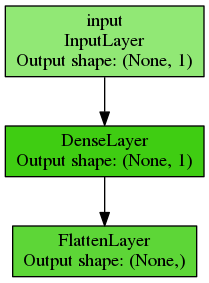

In [5]:
draw_to_notebook(logreg)

In [6]:
X_pos = T.fmatrix()
X_neg = T.fmatrix()
w = T.fvector()

In [7]:
f_pos, = logreg(X_pos)
f_neg, = logreg(X_neg)

In [8]:
losses = (T.nnet.softplus(-f_pos) + T.nnet.softplus(f_neg)) / 2

loss = T.mean(w * losses)

In [9]:
grad = theano.grad(T.sum(losses), logreg.params())
grad_norm = T.sqrt(
    lsum([ T.sum(g ** 2) for g in grad ])
)

In [10]:
get_grad_norm = theano.function([X_pos, X_neg], grad_norm)

In [11]:
learning_rate = T.fscalar()

upd, rst = resetable.adam(grad, logreg.params(), learning_rate=learning_rate)

train = theano.function(
    [X_pos, X_neg, w, learning_rate],
    [loss, grad_norm],
    updates=upd, allow_input_downcast=True
)

reset = theano.function([], None, updates=rst)

## Data

In [12]:
data_pos = np.random.normal(size=(250, )).astype('float32') + 1.25
data_neg = np.random.normal(size=(250, )).astype('float32') + 0.75

data_pos = np.sort(data_pos)
data_neg = np.sort(data_neg)

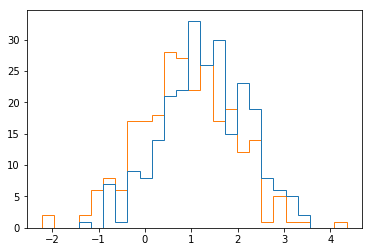

In [13]:
_ = plt.hist([data_pos, data_neg], histtype='step', bins=25)

In [14]:
r = np.abs(data_pos - data_neg)

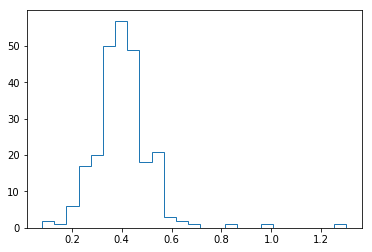

In [15]:
_ = plt.hist(r, histtype='step', bins=25)

## Obtaining solution

In [16]:
initial_params = logreg.weights

In [17]:
num_epoches = 5000
losses = np.ndarray(shape=(num_epoches, ), dtype='float32')
w = np.ones(shape=(data_pos.shape[0], ), dtype='float32')
for i in range(num_epoches):
    losses[i], _ = train(data_pos.reshape(-1, 1), data_neg.reshape(-1, 1), w, 1.0e-3)

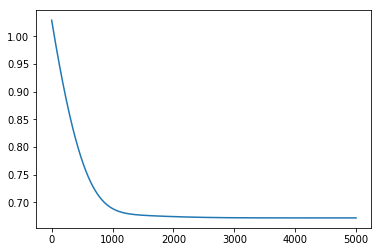

In [18]:
_ = plt.plot(losses)

In [19]:
solution = logreg.weights

## Uniform sampling

In [20]:
sampler = SimpleSampler(n_objects=data_pos.shape[0])

In [21]:
num_epoches = 1000
num_batches = 10

losses = np.ndarray(shape=(num_epoches, num_batches), dtype='float32')
r = np.ndarray(shape=(num_epoches, ), dtype='float64')

In [22]:
logreg.weights = initial_params
reset()

for epoch in range(num_epoches):
    sampler.update()
    prior = 1.0 / data_pos.shape[0]
    indx, probs = sampler.sample(num_batches)

    for i in range(num_batches):
        losses[epoch, i], grad = train(
            np.array([data_pos[indx[i]]], dtype='float32').reshape(-1, 1),
            np.array([data_neg[indx[i]]], dtype='float32').reshape(-1, 1),
            np.array([prior / probs[i]]),
            1.0e-4
        )
    
    r[epoch] = np.sqrt(
        np.sum([ (p-p0) ** 2 for p, p0 in zip(logreg.weights, solution) ])
    )

In [23]:
loss_means = np.mean(losses, axis=1)
loss_stds = np.std(losses, axis=1)

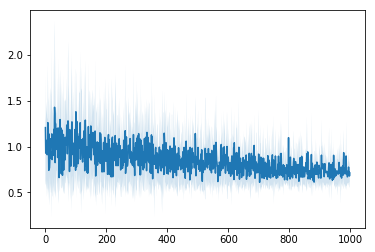

In [24]:
plt.plot(loss_means)
plt.fill_between(np.arange(loss_means.shape[0]), loss_means - loss_stds, loss_means + loss_stds, alpha=0.2)

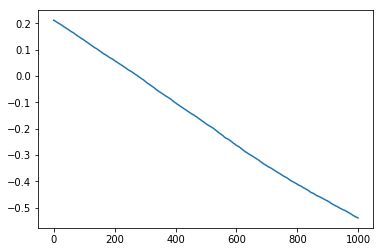

In [25]:
plt.plot(np.log(r))

## Ideal sampling

In [26]:
losses2 = np.ndarray(shape=(num_epoches, num_batches), dtype='float32')
r2 = np.ndarray(shape=(num_epoches, ), dtype='float64')

In [27]:
logreg.weights = initial_params
reset()

prior = 1.0 / data_pos.shape[0]

for epoch in range(num_epoches):
    grads = np.array([
        get_grad_norm(data_pos[k].reshape(-1, 1), data_neg[k].reshape(-1, 1))
        for k in range(data_pos.shape[0])
    ])

    sampler.set_probas(grads)
    sampler.update()

    indx, probs = sampler.sample(num_batches)

    for i in range(num_batches):
        w = prior / probs[i]
        losses2[epoch, i], _ = train(
            np.array([data_pos[indx[i]]], dtype='float32').reshape(-1, 1),
            np.array([data_neg[indx[i]]], dtype='float32').reshape(-1, 1),
            np.array([w], dtype='float32'),
            1.0e-4
        )
        
    r2[epoch] = np.sqrt(
        np.sum([ (p-p0) ** 2 for p, p0 in zip(logreg.weights, solution) ])
    )

In [28]:
loss_means = np.mean(losses2, axis=1)
loss_stds = np.std(losses2, axis=1)

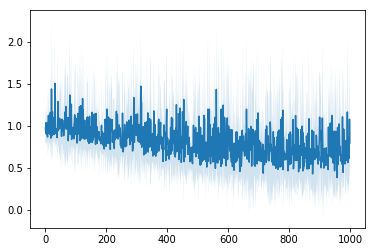

In [29]:
plt.plot(loss_means)
plt.fill_between(np.arange(loss_means.shape[0]), loss_means - loss_stds, loss_means + loss_stds, alpha=0.2)

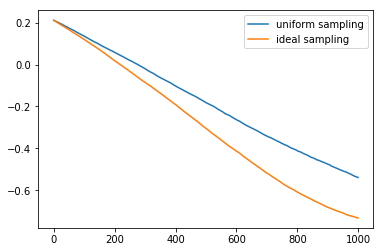

In [30]:
plt.plot(np.log(r), label='uniform sampling')
plt.plot(np.log(r2), label='ideal sampling')
plt.legend()